In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import RidgeCV, SGDRegressor, LogisticRegressionCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from tqdm.notebook import tqdm
# from autoviz.AutoViz_Class import AutoViz_Class
from pandas_profiling import ProfileReport
import datetime
from time import sleep, time
import re

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RANDOM_SEED = 42

In [3]:
data = pd.read_csv('data/data-2018.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149790 entries, 0 to 149789
Columns: 267 entries, name to subject_rf
dtypes: float64(1), int64(264), object(2)
memory usage: 305.1+ MB


In [4]:
data.head()

,name,okpo,okopf,okfs,okved,org_inn,measure,type,ind_11103,ind_11104,...,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003,extra_field,subject_rf
0,"МЕСТНАЯ ОБЩЕСТВЕННАЯ ОРГАНИЗАЦИЯ ""ГОРНОЛЫЖНЫЙ ...",46256621,20200,53,94.99,4712016336,384,1,0,0,...,0,0,0,0,0,0,317,-317,20190723,NaN
1,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""АКИМОВ""",49992214,12300,16,32.12.5,7825120661,384,2,0,0,...,0,0,0,0,0,0,0,0,20190723,78.0
2,Автономная некоммерческая организация культуры...,52197472,71400,16,90.04,7840290682,384,2,0,0,...,0,0,0,0,0,0,0,0,20190723,NaN
3,Санкт-Петербургское региональное отделение Общ...,54237632,20200,53,94.99,7811290991,384,2,0,0,...,0,0,0,0,0,13,185,90,20190723,NaN
4,ЧАСТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ДОПОЛНИТЕЛЬ...,55743981,75500,16,85.42,4345023736,384,1,0,0,...,0,0,0,0,0,0,0,0,20190712,NaN


In [5]:
num_features = [c for c in data.columns if c.startswith('ind_') and c.endswith('3')]
num_features[:10]

['ind_11103',
 'ind_11203',
 'ind_11303',
 'ind_11403',
 'ind_11503',
 'ind_11603',
 'ind_11703',
 'ind_11803',
 'ind_11903',
 'ind_11003']

In [6]:
data_ind = (data[num_features] != 0).astype('int8')
data_ind

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149786,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149787,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(data_ind)
np.unique(clustering.labels_, return_counts=True)

(array([  -1,    0,    1, ..., 2149, 2150, 2151]),
 array([52165,   531,    94, ...,     5,     5,     5]))

In [8]:
data_ind_smp = data_ind.sample(1000)

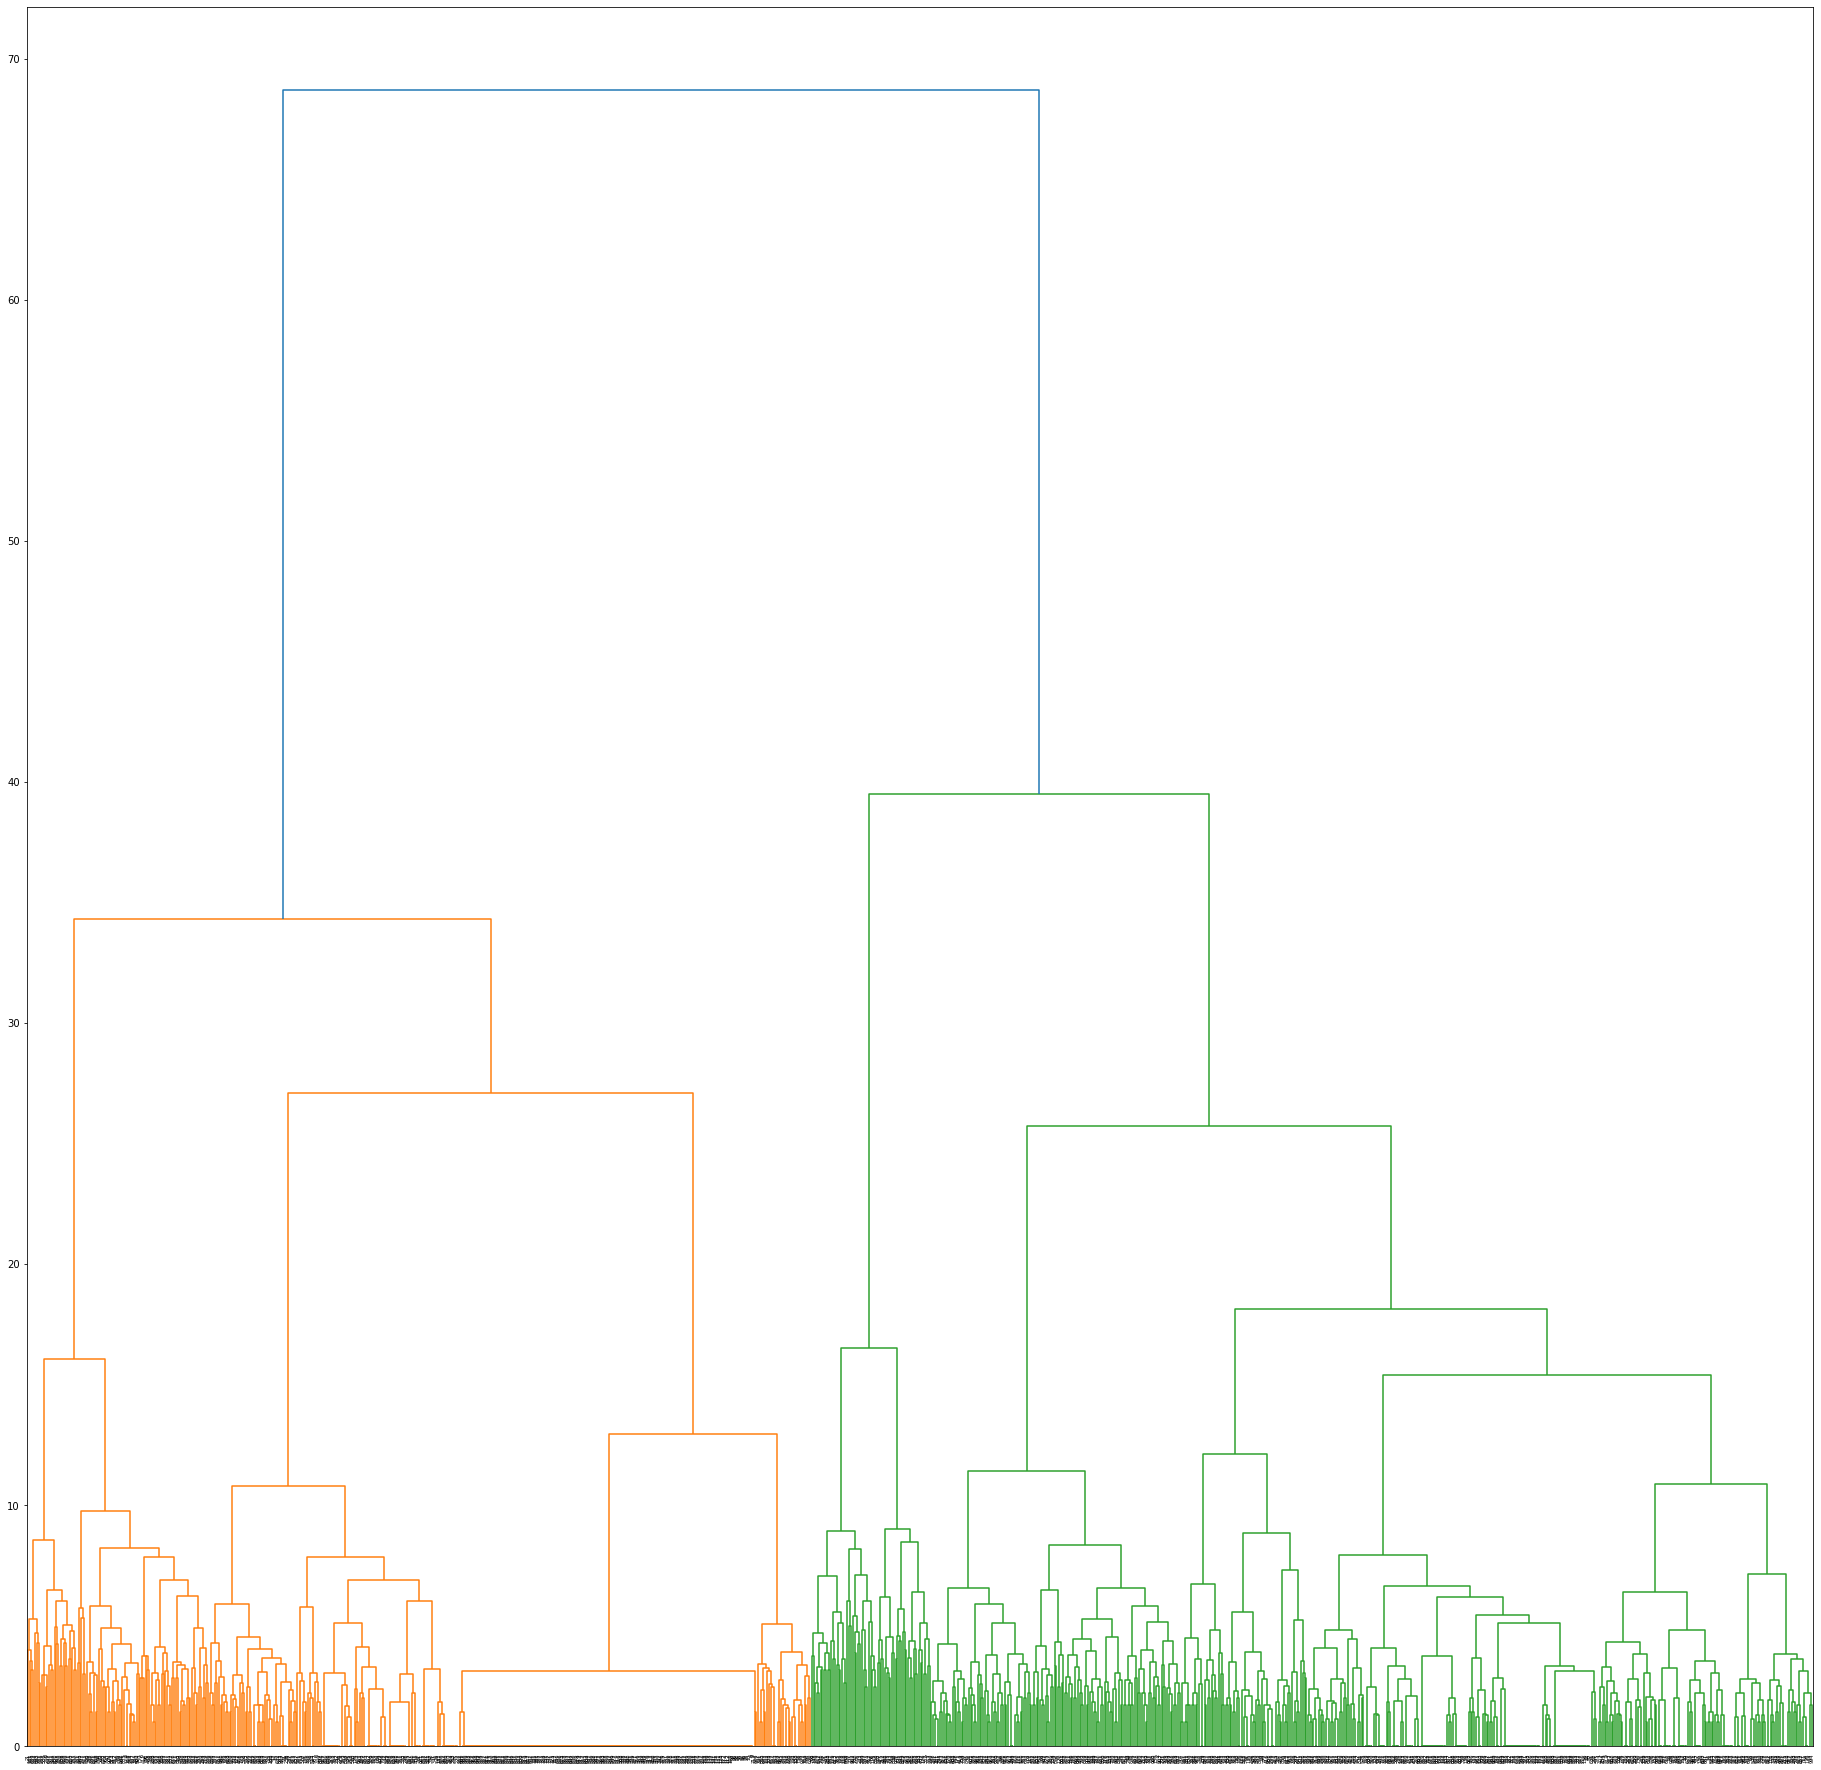

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data_ind_smp, method='ward', metric='euclidean')
fig = plt.figure(figsize=(32, 32))
dend = dendrogram(Z)

In [26]:
from scipy.cluster.hierarchy import fcluster
t = 60
labels = fcluster(Z, t, criterion='distance')
np.unique(labels, return_counts=True)

(array([1, 2], dtype=int32), array([439, 561]))

In [28]:
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=60)
clustering.fit(data_ind_smp)
np.unique(clustering.labels_, return_counts=True)

(array([0, 1]), array([561, 439]))

In [29]:
data_ind_smp['labels'] = labels
data_ind_smp.head()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003,labels
86045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
90557,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2
18131,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,2
35671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
8865,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
diff_df = data_ind_smp.groupby('labels').mean().T
diff_df.columns = ['cls1', 'cls2']
diff_df

,cls1,cls2
ind_11103,0.009112,0.057041
ind_11203,0.000000,0.003565
ind_11303,0.000000,0.000000
ind_11403,0.000000,0.000000
ind_11503,0.079727,0.356506
...,...,...
ind_63263,0.068337,0.008913
ind_63303,0.050114,0.003565
ind_63503,0.111617,0.005348
ind_63003,0.289294,0.023173


In [42]:
diff_df['diff'] = (diff_df['cls1'] - diff_df['cls2']).abs()
diff_df.sort_values(by='diff', ascending=False)

,cls1,cls2,diff
ind_23003,0.054670,0.992870,0.938200
ind_24003,0.054670,0.987522,0.932853
ind_22003,0.047836,0.960784,0.912948
ind_21003,0.050114,0.932264,0.882150
ind_21103,0.063781,0.898396,0.834614
...,...,...,...
ind_43213,0.000000,0.000000,0.000000
ind_33263,0.000000,0.000000,0.000000
ind_11403,0.000000,0.000000,0.000000
ind_11303,0.000000,0.000000,0.000000


In [15]:
data_ind_smp[data_ind_smp['labels'] == 2].head()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003,labels
28200,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
23692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
55148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
118013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
44834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [39]:
sample_data = data.sample(1000)

In [40]:
X = preprocessing.StandardScaler().fit_transform(sample_data[num_features])
X.shape

(1000, 131)

In [41]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN().fit(X)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0]), array([176, 824]))

In [42]:
# %%time
# from sklearn.manifold import MDS
# from sklearn.metrics.pairwise import pairwise_distances
# MDS_transformed = MDS(random_state=RANDOM_SEED).fit_transform(X)
# print(MDS_transformed.shape)

In [43]:
# plt.figure(figsize=(16, 16))
# plt.scatter(MDS_transformed[:, 0], MDS_transformed[:, 1])

In [44]:
%%time
from sklearn.manifold import TSNE
tsne_representation = TSNE(random_state=RANDOM_SEED).fit_transform(X)
print(tsne_representation.shape)

(1000, 2)
CPU times: user 32.4 s, sys: 811 ms, total: 33.2 s
Wall time: 4.76 s


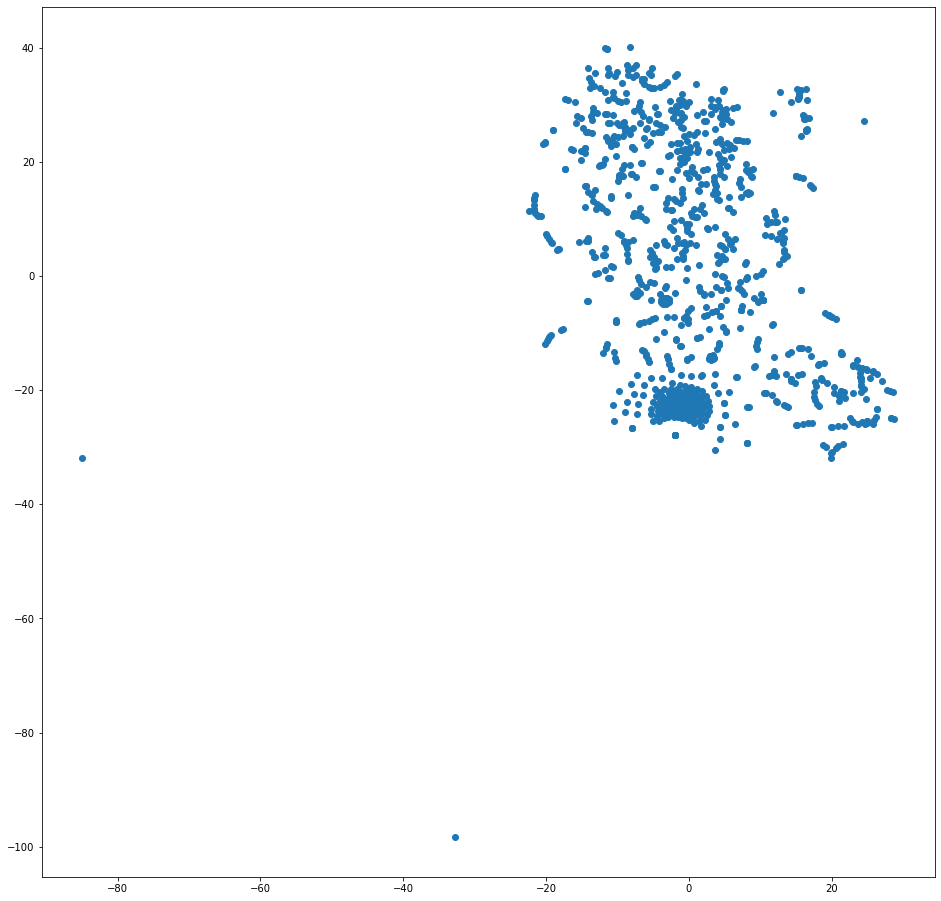

In [45]:
plt.figure(figsize=(16, 16))
plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1])

In [46]:
%%time
from sklearn.manifold import TSNE
tsne_representation = TSNE(random_state=RANDOM_SEED, n_components=2).fit_transform(X)
print(tsne_representation.shape)

(1000, 2)
CPU times: user 33.8 s, sys: 1.11 s, total: 34.9 s
Wall time: 5.44 s


In [47]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=2).fit(tsne_representation)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36]),
 array([103,  11, 251,  11,  57,  18,  34,  11,   7,   6,  60,   9,   6,
          7,  22,   8,  13,  43,  24,  12,  33,  11,   7,   6, 117,   5,
          7,  11,  10,  15,   7,   7,   8,  11,   9,  12,   6,   5]))

In [48]:
from sklearn.cluster import OPTICS
clustering = OPTICS(min_samples=10).fit(tsne_representation)
np.unique(clustering.labels_, return_counts=True)

/Users/sand/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24]),
 array([460,  12,  10,  27,  20,  22,  11,  12,  13,  13,  25,  12,  17,
         13,  15,  10,  18,  17,  14, 101,  60,  22,  10,  31,  21,  14]))

In [49]:
# строим матрицу смежности
# connectivity = kneighbors_graph(tsne_representation, n_neighbors=2, include_self=False)
# connectivity

In [50]:
# clustering = AgglomerativeClustering(n_clusters=10, connectivity=connectivity)
# clustering.fit(X)

In [51]:
# np.unique(clustering.labels_, return_counts=True)

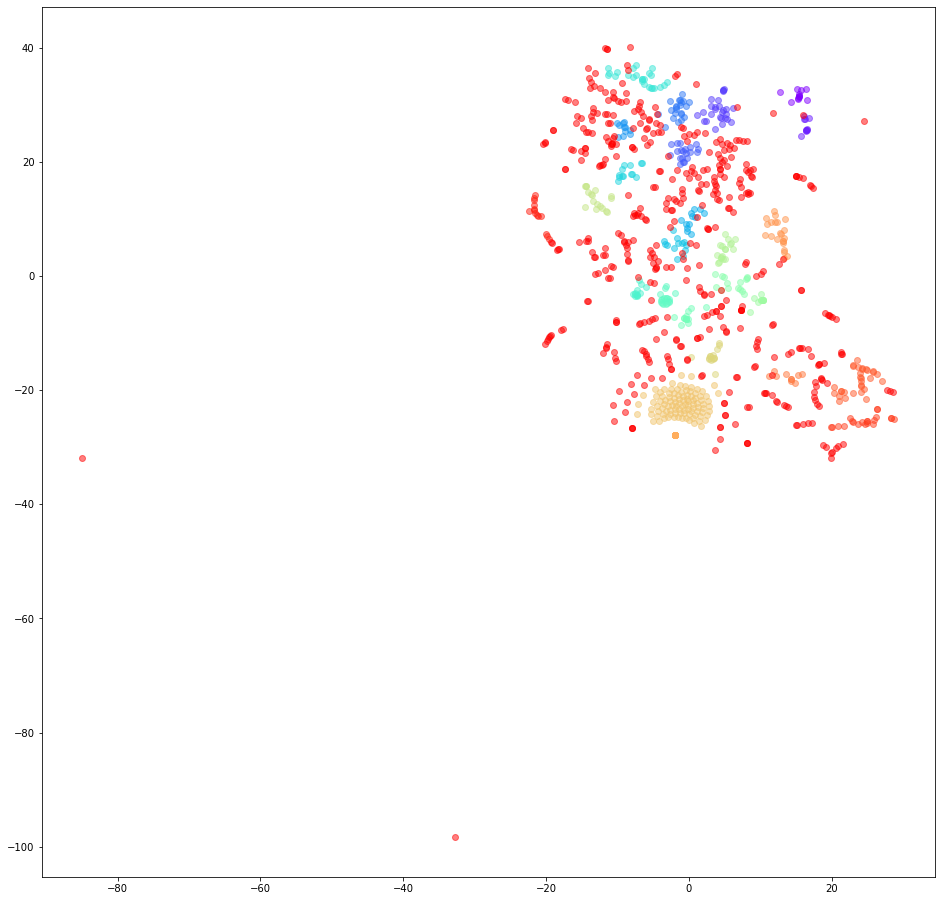

In [52]:
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
plt.figure(figsize=(16, 16))
y = clustering.labels_
colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for v, c in zip(set(y), colors):
    plt.scatter(tsne_representation[y==v, 0],
                tsne_representation[y==v, 1],
                c=c.reshape(1,-1), alpha=0.5, label=str(v))


In [53]:
# строим матрицу смежности
connectivity = kneighbors_graph(tsne_representation, n_neighbors=100, mode='connectivity', include_self=False)
connectivity

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [54]:
# connectivity = 0.5 * (connectivity + connectivity.T)
# connectivity

In [55]:
# clustering = AgglomerativeClustering(n_clusters=None, connectivity=connectivity, compute_full_tree=True, distance_threshold=1000)
# clustering.fit(X)

In [56]:
# np.unique(clustering.labels_, return_counts=True)

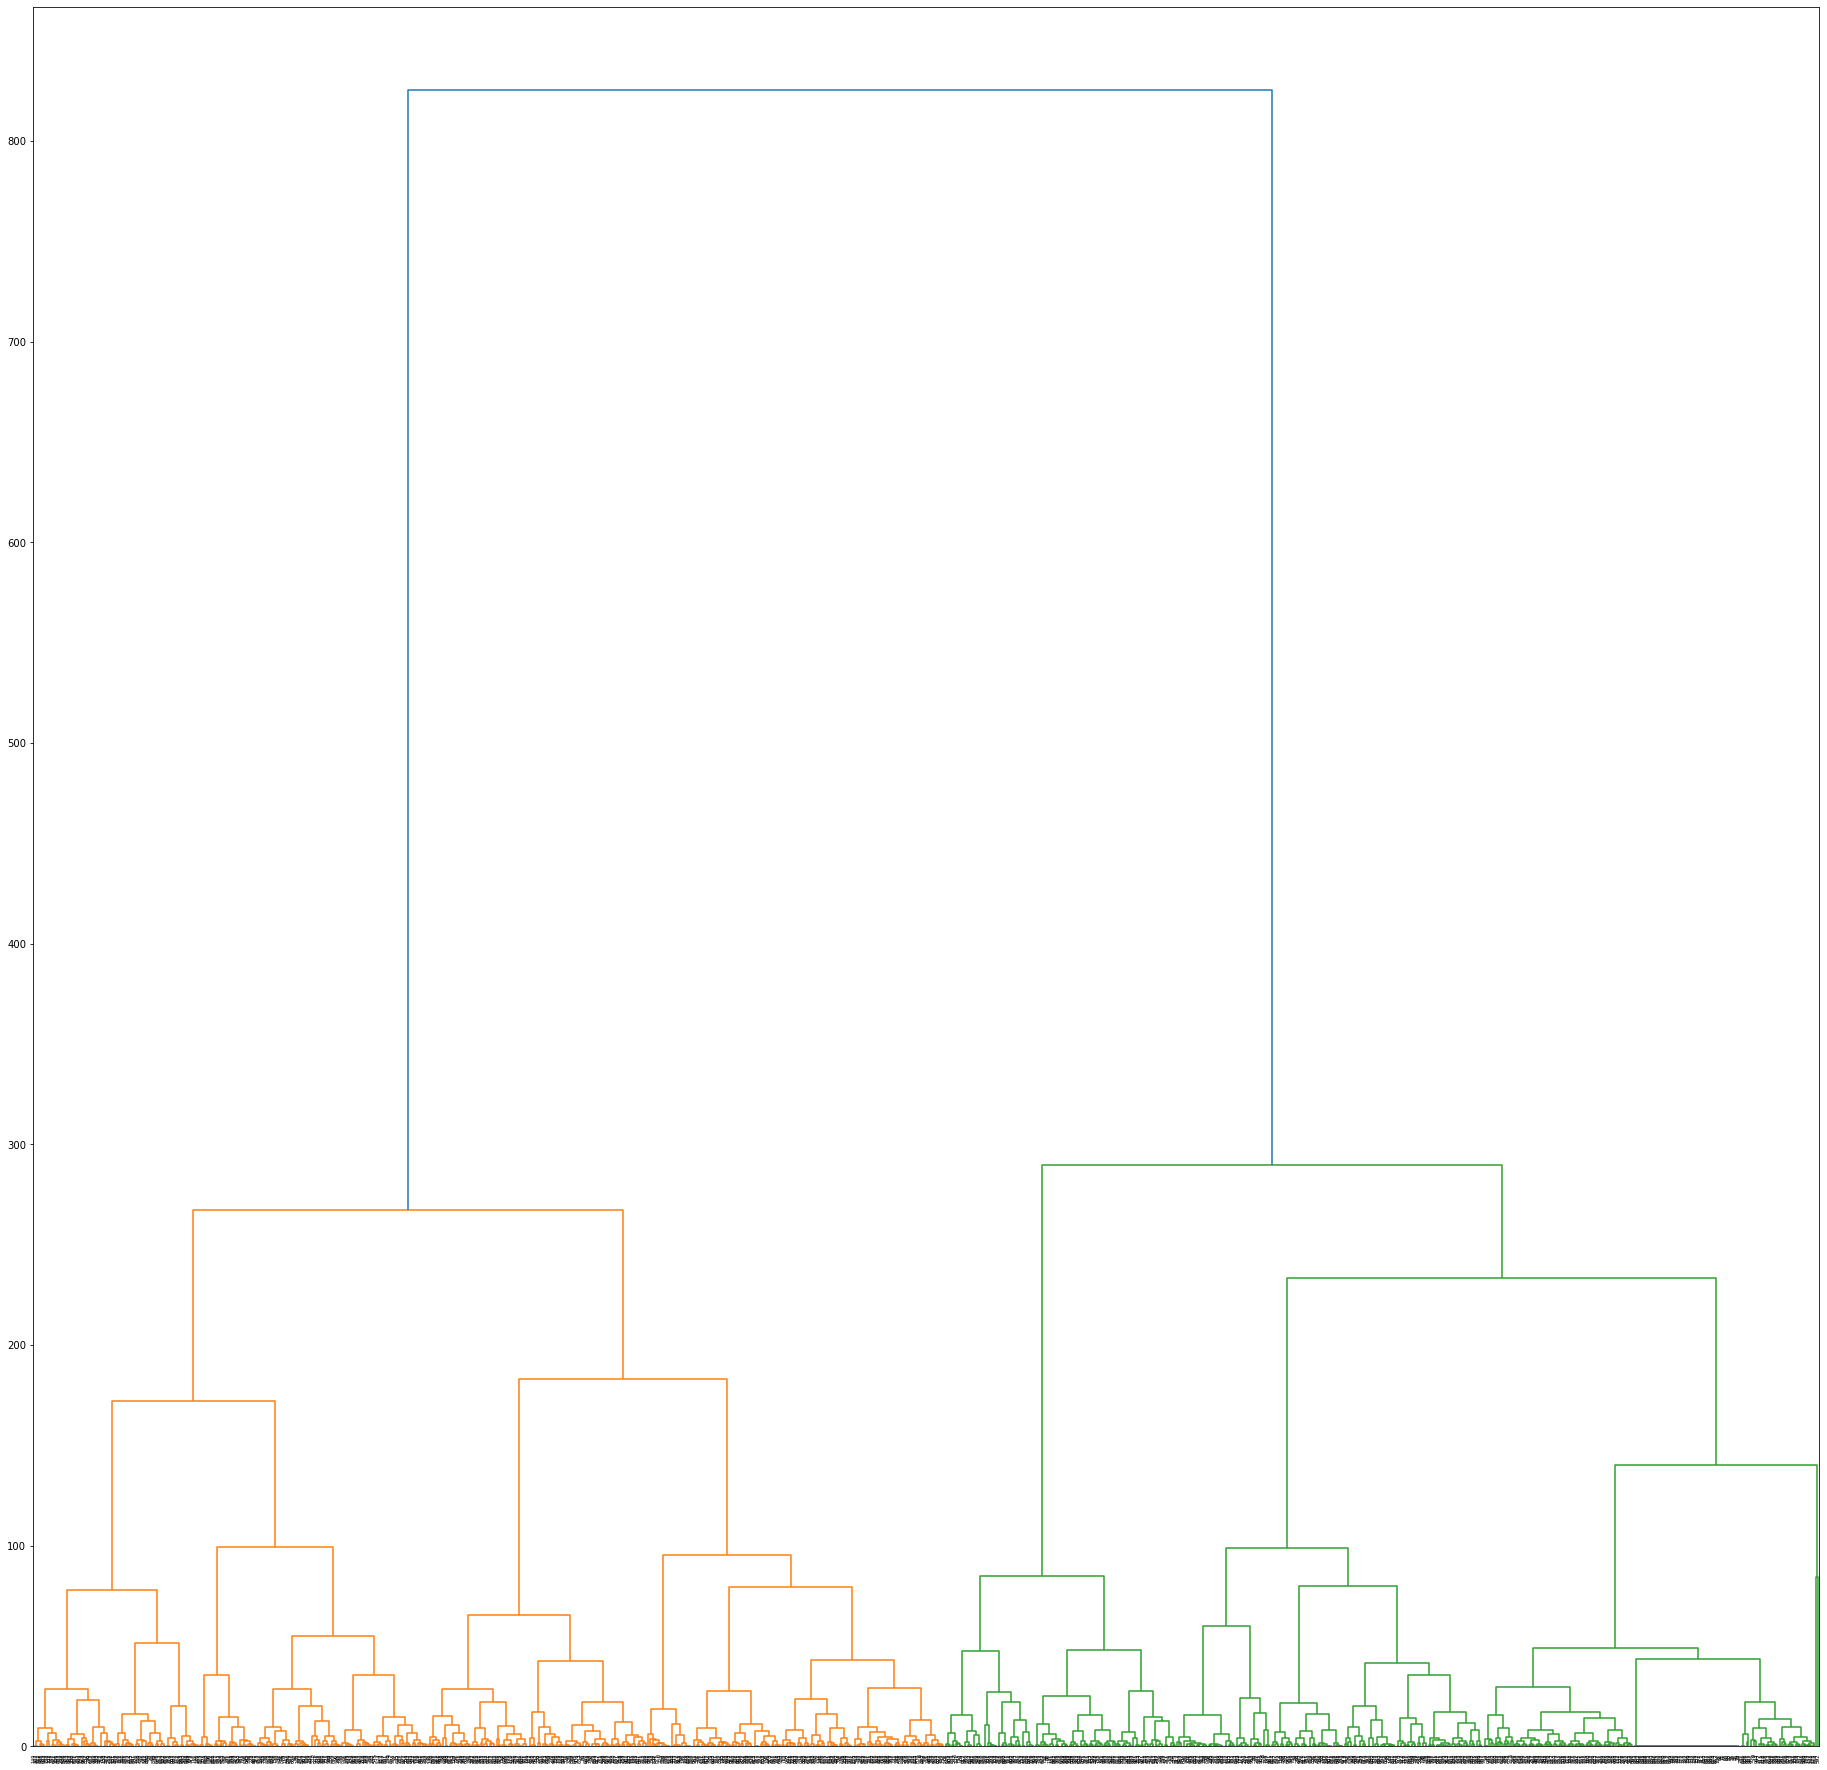

In [57]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(tsne_representation, method='ward', metric='euclidean')
fig = plt.figure(figsize=(32, 32))
dend = dendrogram(Z)

In [80]:
from scipy.cluster.hierarchy import fcluster
t = 300
labels = fcluster(Z, t, criterion='distance')

In [81]:
np.unique(labels, return_counts=True)

(array([1, 2], dtype=int32), array([510, 490]))

In [82]:
# clustering.labels_

In [92]:
clustering = AgglomerativeClustering(n_clusters=None, connectivity=connectivity, compute_full_tree=True, distance_threshold=200)
clustering.fit(tsne_representation)
np.unique(clustering.labels_, return_counts=True)

(array([0, 1, 2, 3, 4]), array([289, 222, 130, 187, 172]))

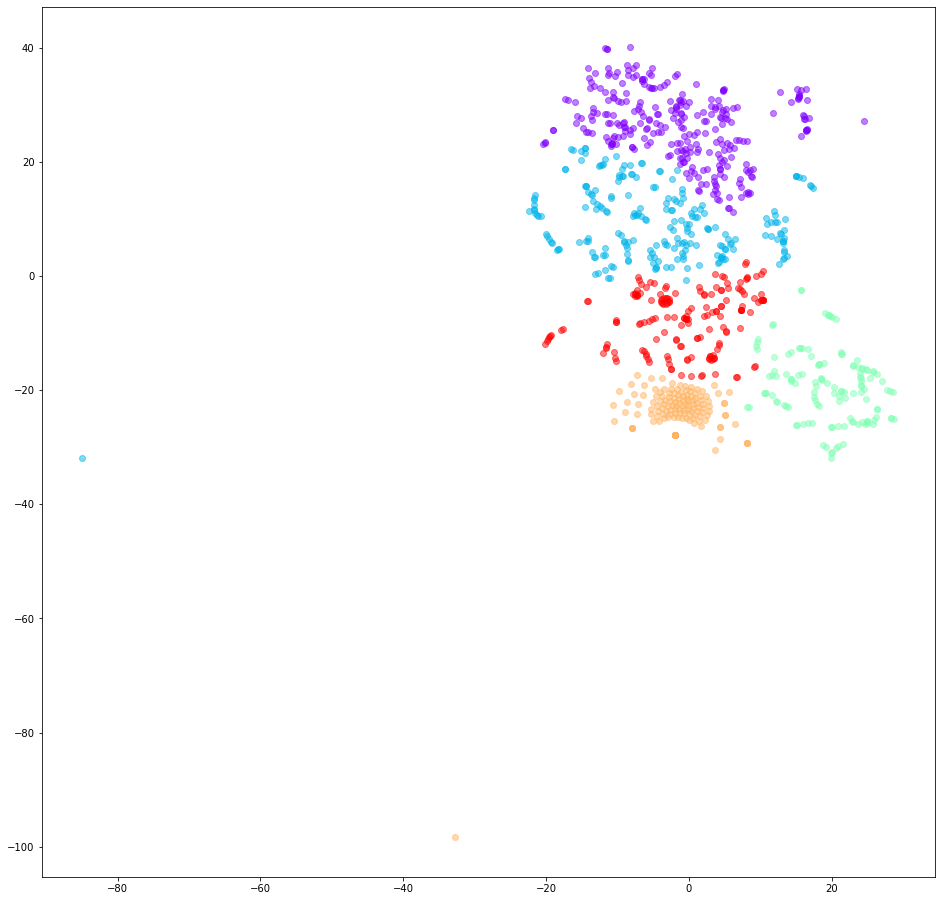

In [93]:
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
plt.figure(figsize=(16, 16))
y = clustering.labels_
colors = cm.rainbow(np.linspace(0, 1, len(set(y))))
for v, c in zip(set(y), colors):
    plt.scatter(tsne_representation[y==v, 0],
                tsne_representation[y==v, 1],
                c=c.reshape(1,-1), alpha=0.5, label=str(v))

In [86]:
sample_data['tsne_0'] = tsne_representation[:, 0]
sample_data['tsne_1'] = tsne_representation[:, 1]
sample_data['label'] = clustering.labels_
sample_data.head()

,name,okpo,okopf,okfs,okved,org_inn,measure,type,ind_11103,ind_11104,...,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003,extra_field,subject_rf,tsne_0,tsne_1,label
132222,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ПРАЗДНИК""",45417329,12267,16,58.19,7710216208,384,2,0,0,...,0,0,0,0,0,20190326,77.0,16.583300,30.874897,1
61147,"Общество с ограниченной ответственностью ""ГеоСИМ""",85609872,65,16,71.1,3445094552,384,1,0,0,...,0,0,0,0,0,20190718,34.0,-11.293059,23.681755,1
41611,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""РГК-...",91136509,12300,16,71.1,2320190308,384,2,0,0,...,0,0,0,0,0,20190416,NaN,-4.011172,18.372265,1
12803,НАЦИОНАЛЬНАЯ АССОЦИАЦИЯ ПРЕДПРИЯТИЙ ТЕКСТИЛЬНО...,15469010,20600,16,94.12,7706448213,384,0,0,0,...,0,0,0,24,224,20190701,NaN,13.604518,-17.137278,0
42470,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ФРЕГ...",77792402,12300,16,62.01,7810042675,384,2,0,0,...,0,0,0,0,0,20190723,78.0,-2.466531,1.606209,1


In [87]:
sample_data.loc[sample_data['label'] == 0, num_features].describe()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
count,489.000000,489.000000,489.0,489.0,489.000000,489.0,489.000000,489.000000,489.000000,489.000000,...,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000
mean,6.979550,11.928425,0.0,0.0,202.118609,0.0,483.854806,0.040900,1.922290,706.770961,...,253.110429,1.830266,2.543967,32.239264,0.940695,29.151329,17.605317,89.783231,1205.723926,2096.014315
std,83.976599,263.777378,0.0,0.0,2576.951549,0.0,10538.219784,0.904431,30.359629,10853.520797,...,2520.002268,17.407655,29.643694,259.757504,13.748568,306.403800,156.258238,963.434457,8463.826911,31931.282702
min,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-219.000000
25%,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000
max,1350.000000,5833.000000,0.0,0.0,55610.000000,0.0,233037.000000,20.000000,540.000000,233037.000000,...,48340.000000,262.000000,619.000000,3828.000000,266.000000,6100.000000,2787.000000,20519.000000,154227.000000,660969.000000


In [88]:
sample_data.loc[sample_data['label'] == 1, num_features].describe()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
count,511.000000,511.000000,511.0,511.0,511.000000,511.000000,511.00000,511.000000,511.000000,5.110000e+02,...,511.0,511.0,511.0,511.0,511.0,511.000000,511.000000,511.0,511.000000,511.000000
mean,2409.324853,100.050881,0.0,0.0,4980.497065,5.788650,2612.46771,916.405088,549.818004,1.157435e+04,...,0.0,0.0,0.0,0.0,0.0,0.001957,0.318982,0.0,3.641879,9.156556
std,26824.521777,1421.721247,0.0,0.0,43852.488291,130.854216,43926.37274,17322.082480,11488.421965,1.070108e+05,...,0.0,0.0,0.0,0.0,0.0,0.044237,7.210695,0.0,74.336588,206.189792
min,0.000000,0.000000,0.0,0.0,-88.000000,0.000000,0.00000,0.000000,0.000000,-8.800000e+01,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.0,0.0,168.500000,0.000000,0.00000,0.000000,0.000000,4.865000e+02,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
max,456646.000000,27549.000000,0.0,0.0,613411.000000,2958.000000,970432.00000,388727.000000,259049.000000,2.054498e+06,...,0.0,0.0,0.0,0.0,0.0,1.000000,163.000000,0.0,1670.000000,4661.000000


In [73]:
sample_data.loc[sample_data['label'] == 2, num_features].describe()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
count,130.000000,130.0,130.0,130.0,130.000000,130.0,130.000000,130.0,130.000000,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,1.238462,0.0,0.0,0.0,660.507692,0.0,1816.476923,0.0,3.076923,2481.023077,...,945.638462,6.884615,9.569231,121.246154,3.538462,106.784615,66.223077,332.823077,4183.053846,7782.276923
std,13.515884,0.0,0.0,0.0,4914.407881,0.0,20437.047349,0.0,35.082321,20962.203402,...,4833.454322,33.335651,57.065845,494.343619,26.566912,588.646891,298.533477,1851.503916,15843.636507,61744.955965
min,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-219.000000
25%,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,188.750000,0.000000
50%,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,627.500000,39.500000
75%,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,6.500000,...,53.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,62.000000,1824.750000,276.000000
max,154.000000,0.0,0.0,0.0,55610.000000,0.0,233037.000000,0.0,400.000000,233037.000000,...,48340.000000,262.000000,619.000000,3828.000000,266.000000,6100.000000,2787.000000,20519.000000,154227.000000,660969.000000


In [74]:
sample_data.loc[sample_data['label'] == 3, num_features].describe()

,ind_11103,ind_11203,ind_11303,ind_11403,ind_11503,ind_11603,ind_11703,ind_11803,ind_11903,ind_11003,...,ind_63213,ind_63223,ind_63233,ind_63243,ind_63253,ind_63263,ind_63303,ind_63503,ind_63003,ind_64003
count,166.000000,166.0,166.0,166.0,166.000000,166.0,166.000000,166.000000,166.000000,166.000000,...,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0,166.0
mean,24.915663,0.0,0.0,0.0,272.927711,0.0,64.409639,4.337349,4.150602,370.740964,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,316.740663,0.0,0.0,0.0,1206.234695,0.0,418.553455,33.518435,43.175978,1348.158811,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.0,0.0,0.0,76.000000,0.0,0.000000,0.000000,0.000000,113.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,4081.000000,0.0,0.0,0.0,14197.000000,0.0,4000.000000,345.000000,549.000000,14790.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
